In [223]:

import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torch.utils.data
import torch.nn.functional as F

In [224]:
#seed
manual_seed = 99
torch.manual_seed(manual_seed)
torch.use_deterministic_algorithms(True)

In [225]:
device = "gpu" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [226]:
import math
image_channels = 1

In [227]:
#building a generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 256, 7, 1, 0),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, image_channels, 4, 2, 1),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)
           

In [228]:
generator = Generator()
print(generator)

Generator(
  (model): Sequential(
    (0): ConvTranspose2d(100, 256, kernel_size=(7, 7), stride=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(128, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): Tanh()
  )
)


In [229]:
#discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(image_channels, 128, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 1, 7, 1, 0),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [230]:
discriminator = Discriminator()
print(discriminator)

Discriminator(
  (model): Sequential(
    (0): Conv2d(1, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(256, 1, kernel_size=(7, 7), stride=(1, 1))
    (6): Sigmoid()
  )
)


In [231]:
#using MNIST dataset to check whether the generator and discriminator are working

mnist_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5,0.5) #to get image in range
])

data_mnist = datasets.MNIST(
            root= 'Notebooks/MNIST_data',
            train= True,
            download=True,
            transform = mnist_transform)

In [232]:
#viewing data
print(data_mnist[0])

(tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -

The lenght of the MNIST data : 60000
torch.Size([1, 28, 28])
torch.Size([28, 28])


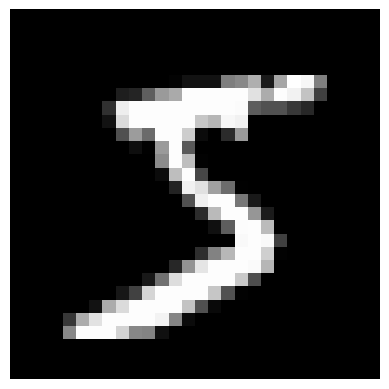

In [233]:
import matplotlib.pyplot as plt

print(f"The lenght of the MNIST data : {len(data_mnist)}")

image, label = data_mnist[0]
print(image.shape)
plt.imshow(image.squeeze(0), cmap="gray") #to remove the batch size element 
plt.axis("off")
print(image.squeeze(0).shape)


In [234]:
#Dataloader
train_dataloader = torch.utils.data.DataLoader(dataset = data_mnist,
                                              shuffle=True,
                                              num_workers=3,
                                              drop_last=True,
                                              batch_size = 64)

torch.Size([1, 28, 28])


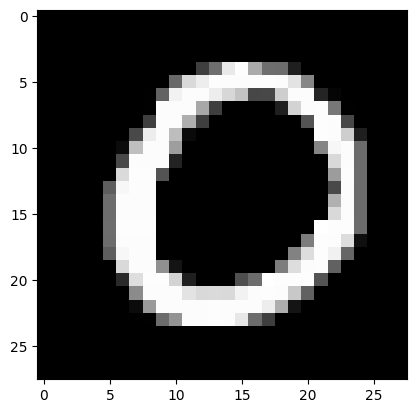

In [235]:
imgs, labels = next(iter(train_dataloader))

test_img , test_label= imgs[0], labels[0].item()
#print(test_img)
print(test_img.shape)
plt.imshow(test_img.squeeze(0), cmap="gray")

In [236]:
#checking discriminator
dic_check = discriminator(test_img.unsqueeze(dim = 0).to(device))
dic_check

tensor([[[[0.6171]]]], grad_fn=<SigmoidBackward0>)

In [237]:

'''
#checking generator
#generator = generator().to(device)
#discriminator = discriminator().to(device)

torch.manual_seed(manual_seed)
generator.eval()
#noise
noise = torch.randn(1, 100, device=device).to(device)
print(f"The shape of the noise is {noise.shape}")
gen_check = generator(noise).to(device)
print(f"The shape of the generated image is {gen_check.shape}")

plt.imshow(gen_check.cpu().detach().squeeze(),
           cmap = "gray");
plt.axis('off')
print(f"The dimensions of the image is {gen_check.cpu().detach().squeeze().shape}")'''


'\n#checking generator\n#generator = generator().to(device)\n#discriminator = discriminator().to(device)\n\ntorch.manual_seed(manual_seed)\ngenerator.eval()\n#noise\nnoise = torch.randn(1, 100, device=device).to(device)\nprint(f"The shape of the noise is {noise.shape}")\ngen_check = generator(noise).to(device)\nprint(f"The shape of the generated image is {gen_check.shape}")\n\nplt.imshow(gen_check.cpu().detach().squeeze(),\n           cmap = "gray");\nplt.axis(\'off\')\nprint(f"The dimensions of the image is {gen_check.cpu().detach().squeeze().shape}")'

It seems like both the generator and discriminator is working.

The image generatored is random because of the random tensors

In [238]:
num_epochs = 50
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr = 0.0002)
optimizer_g = torch.optim.Adam(generator.parameters(), lr = 0.0002)

criterion = nn.BCELoss()
latent_dim = 100
batch_size

128

Epoch [1/50], Batch [100/937], D_real: 0.9996, D_fake: 0.0009, Loss_D: 0.0013, Loss_G: 7.1306
Epoch [1/50], Batch [200/937], D_real: 0.9991, D_fake: 0.0401, Loss_D: 0.0419, Loss_G: 9.0290
Epoch [1/50], Batch [300/937], D_real: 0.9981, D_fake: 0.0000, Loss_D: 0.0019, Loss_G: 12.4150
Epoch [1/50], Batch [400/937], D_real: 0.9239, D_fake: 0.0001, Loss_D: 0.1185, Loss_G: 11.0484
Epoch [1/50], Batch [500/937], D_real: 0.9997, D_fake: 0.0398, Loss_D: 0.0417, Loss_G: 6.2196
Epoch [1/50], Batch [600/937], D_real: 0.9998, D_fake: 0.0017, Loss_D: 0.0020, Loss_G: 7.6038
Epoch [1/50], Batch [700/937], D_real: 0.9994, D_fake: 0.0011, Loss_D: 0.0018, Loss_G: 8.4701
Epoch [1/50], Batch [800/937], D_real: 0.9944, D_fake: 0.0004, Loss_D: 0.0063, Loss_G: 9.3125
Epoch [1/50], Batch [900/937], D_real: 0.9997, D_fake: 0.0003, Loss_D: 0.0006, Loss_G: 8.8862


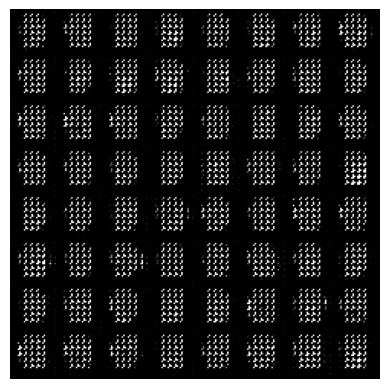

Epoch [2/50], Batch [100/937], D_real: 1.0000, D_fake: 0.0005, Loss_D: 0.0005, Loss_G: 8.2110
Epoch [2/50], Batch [200/937], D_real: 1.0000, D_fake: 0.0000, Loss_D: 0.0001, Loss_G: 10.5433
Epoch [2/50], Batch [300/937], D_real: 1.0000, D_fake: 0.0000, Loss_D: 0.0001, Loss_G: 11.5761
Epoch [2/50], Batch [400/937], D_real: 1.0000, D_fake: 0.0001, Loss_D: 0.0001, Loss_G: 11.0241
Epoch [2/50], Batch [500/937], D_real: 0.9999, D_fake: 0.0002, Loss_D: 0.0002, Loss_G: 9.6606
Epoch [2/50], Batch [600/937], D_real: 0.9999, D_fake: 0.0001, Loss_D: 0.0001, Loss_G: 10.1961
Epoch [2/50], Batch [700/937], D_real: 0.9999, D_fake: 0.0001, Loss_D: 0.0001, Loss_G: 10.0723
Epoch [2/50], Batch [800/937], D_real: 1.0000, D_fake: 0.0001, Loss_D: 0.0001, Loss_G: 9.6695
Epoch [2/50], Batch [900/937], D_real: 0.9990, D_fake: 0.0023, Loss_D: 0.0033, Loss_G: 6.9108


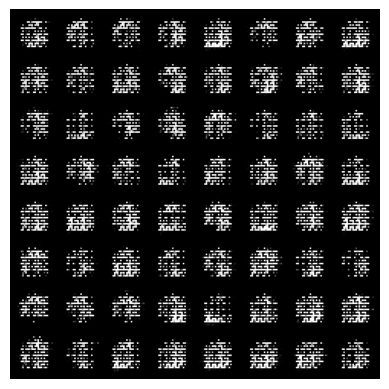

Epoch [3/50], Batch [100/937], D_real: 0.9997, D_fake: 0.0001, Loss_D: 0.0004, Loss_G: 9.9711
Epoch [3/50], Batch [200/937], D_real: 0.9998, D_fake: 0.0006, Loss_D: 0.0007, Loss_G: 8.2890
Epoch [3/50], Batch [300/937], D_real: 0.9959, D_fake: 0.0033, Loss_D: 0.0079, Loss_G: 6.3077
Epoch [3/50], Batch [400/937], D_real: 0.9893, D_fake: 0.0024, Loss_D: 0.0136, Loss_G: 6.8138
Epoch [3/50], Batch [500/937], D_real: 0.9981, D_fake: 0.0127, Loss_D: 0.0152, Loss_G: 6.0590
Epoch [3/50], Batch [600/937], D_real: 0.9645, D_fake: 0.0275, Loss_D: 0.0660, Loss_G: 3.9677
Epoch [3/50], Batch [700/937], D_real: 0.9933, D_fake: 0.0151, Loss_D: 0.0223, Loss_G: 5.6852
Epoch [3/50], Batch [800/937], D_real: 0.9933, D_fake: 0.0932, Loss_D: 0.1141, Loss_G: 5.3264
Epoch [3/50], Batch [900/937], D_real: 0.8937, D_fake: 0.0458, Loss_D: 0.1761, Loss_G: 4.4278


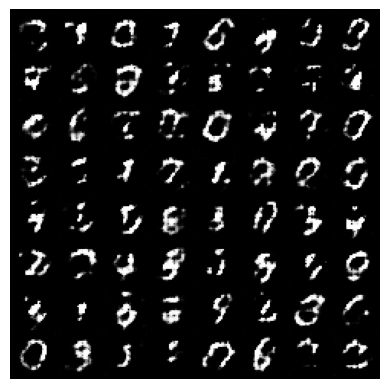

Epoch [4/50], Batch [100/937], D_real: 0.8678, D_fake: 0.0405, Loss_D: 0.2227, Loss_G: 3.8744
Epoch [4/50], Batch [200/937], D_real: 0.9055, D_fake: 0.1513, Loss_D: 0.3059, Loss_G: 3.0469
Epoch [4/50], Batch [300/937], D_real: 0.9397, D_fake: 0.1274, Loss_D: 0.2086, Loss_G: 3.2453
Epoch [4/50], Batch [400/937], D_real: 0.8962, D_fake: 0.1296, Loss_D: 0.2834, Loss_G: 3.1256
Epoch [4/50], Batch [500/937], D_real: 0.8967, D_fake: 0.1356, Loss_D: 0.3061, Loss_G: 3.0007
Epoch [4/50], Batch [600/937], D_real: 0.8386, D_fake: 0.1049, Loss_D: 0.3464, Loss_G: 2.4761
Epoch [4/50], Batch [700/937], D_real: 0.9090, D_fake: 0.1004, Loss_D: 0.2178, Loss_G: 3.0319
Epoch [4/50], Batch [800/937], D_real: 0.7851, D_fake: 0.0687, Loss_D: 0.3699, Loss_G: 3.0383
Epoch [4/50], Batch [900/937], D_real: 0.8829, D_fake: 0.2842, Loss_D: 0.5350, Loss_G: 2.4589


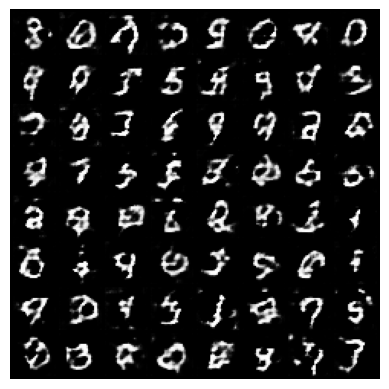

Epoch [5/50], Batch [100/937], D_real: 0.7445, D_fake: 0.0994, Loss_D: 0.4629, Loss_G: 2.6307
Epoch [5/50], Batch [200/937], D_real: 0.7611, D_fake: 0.1646, Loss_D: 0.4999, Loss_G: 2.3587
Epoch [5/50], Batch [300/937], D_real: 0.8282, D_fake: 0.1204, Loss_D: 0.3459, Loss_G: 2.3660
Epoch [5/50], Batch [400/937], D_real: 0.8311, D_fake: 0.1815, Loss_D: 0.4333, Loss_G: 1.3869
Epoch [5/50], Batch [500/937], D_real: 0.9293, D_fake: 0.1566, Loss_D: 0.2577, Loss_G: 2.5335
Epoch [5/50], Batch [600/937], D_real: 0.9348, D_fake: 0.2794, Loss_D: 0.4547, Loss_G: 2.2013
Epoch [5/50], Batch [700/937], D_real: 0.7330, D_fake: 0.0638, Loss_D: 0.4333, Loss_G: 2.8583
Epoch [5/50], Batch [800/937], D_real: 0.7627, D_fake: 0.1280, Loss_D: 0.4652, Loss_G: 1.9739
Epoch [5/50], Batch [900/937], D_real: 0.8785, D_fake: 0.1356, Loss_D: 0.3085, Loss_G: 2.1793


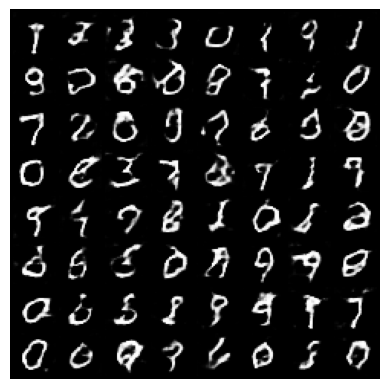

Epoch [6/50], Batch [100/937], D_real: 0.8601, D_fake: 0.1096, Loss_D: 0.2922, Loss_G: 2.0528
Epoch [6/50], Batch [200/937], D_real: 0.8038, D_fake: 0.0837, Loss_D: 0.3461, Loss_G: 2.2669
Epoch [6/50], Batch [300/937], D_real: 0.8465, D_fake: 0.1472, Loss_D: 0.3854, Loss_G: 2.4032
Epoch [6/50], Batch [400/937], D_real: 0.8904, D_fake: 0.0996, Loss_D: 0.2496, Loss_G: 2.5070
Epoch [6/50], Batch [500/937], D_real: 0.8085, D_fake: 0.1028, Loss_D: 0.3721, Loss_G: 1.9360
Epoch [6/50], Batch [600/937], D_real: 0.8340, D_fake: 0.1359, Loss_D: 0.3557, Loss_G: 2.2248
Epoch [6/50], Batch [700/937], D_real: 0.8051, D_fake: 0.1348, Loss_D: 0.4077, Loss_G: 2.6230
Epoch [6/50], Batch [800/937], D_real: 0.9014, D_fake: 0.1949, Loss_D: 0.3633, Loss_G: 2.7638
Epoch [6/50], Batch [900/937], D_real: 0.8351, D_fake: 0.0469, Loss_D: 0.2678, Loss_G: 3.1583


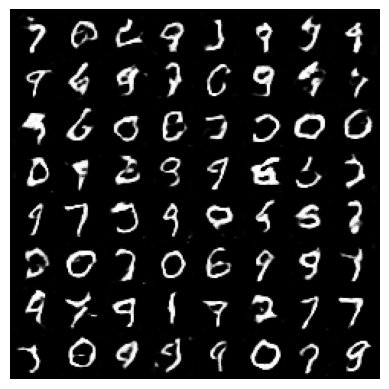

Epoch [7/50], Batch [100/937], D_real: 0.8950, D_fake: 0.1190, Loss_D: 0.2512, Loss_G: 2.6251
Epoch [7/50], Batch [200/937], D_real: 0.9255, D_fake: 0.1592, Loss_D: 0.2768, Loss_G: 2.9620
Epoch [7/50], Batch [300/937], D_real: 0.8164, D_fake: 0.0552, Loss_D: 0.2974, Loss_G: 2.9706
Epoch [7/50], Batch [400/937], D_real: 0.9139, D_fake: 0.1322, Loss_D: 0.2553, Loss_G: 2.9437
Epoch [7/50], Batch [500/937], D_real: 0.9327, D_fake: 0.0752, Loss_D: 0.1620, Loss_G: 3.2205
Epoch [7/50], Batch [600/937], D_real: 0.7770, D_fake: 0.0303, Loss_D: 0.3345, Loss_G: 3.7428
Epoch [7/50], Batch [700/937], D_real: 0.9341, D_fake: 0.0781, Loss_D: 0.1625, Loss_G: 3.0865
Epoch [7/50], Batch [800/937], D_real: 0.8131, D_fake: 0.0200, Loss_D: 0.2665, Loss_G: 4.6712
Epoch [7/50], Batch [900/937], D_real: 0.9279, D_fake: 0.2679, Loss_D: 0.4712, Loss_G: 1.4403


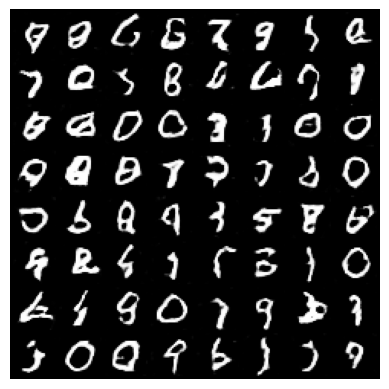

Epoch [8/50], Batch [100/937], D_real: 0.9418, D_fake: 0.1263, Loss_D: 0.2092, Loss_G: 3.2555
Epoch [8/50], Batch [200/937], D_real: 0.7904, D_fake: 0.0112, Loss_D: 0.2818, Loss_G: 4.1022
Epoch [8/50], Batch [300/937], D_real: 0.8753, D_fake: 0.0984, Loss_D: 0.2630, Loss_G: 2.1630
Epoch [8/50], Batch [400/937], D_real: 0.8020, D_fake: 0.0715, Loss_D: 0.3661, Loss_G: 3.1506
Epoch [8/50], Batch [500/937], D_real: 0.8825, D_fake: 0.0918, Loss_D: 0.2747, Loss_G: 4.3034
Epoch [8/50], Batch [600/937], D_real: 0.8826, D_fake: 0.0705, Loss_D: 0.2147, Loss_G: 2.6094
Epoch [8/50], Batch [700/937], D_real: 0.9344, D_fake: 0.2336, Loss_D: 0.3847, Loss_G: 1.9227
Epoch [8/50], Batch [800/937], D_real: 0.7057, D_fake: 0.0280, Loss_D: 0.4413, Loss_G: 3.0163
Epoch [8/50], Batch [900/937], D_real: 0.8811, D_fake: 0.1268, Loss_D: 0.2900, Loss_G: 2.9503


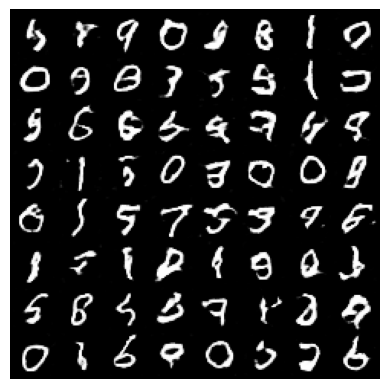

Epoch [9/50], Batch [100/937], D_real: 0.9791, D_fake: 0.2167, Loss_D: 0.3074, Loss_G: 3.4469
Epoch [9/50], Batch [200/937], D_real: 0.8936, D_fake: 0.2463, Loss_D: 0.4963, Loss_G: 1.1573
Epoch [9/50], Batch [300/937], D_real: 0.9059, D_fake: 0.1403, Loss_D: 0.2711, Loss_G: 2.3056
Epoch [9/50], Batch [400/937], D_real: 0.9545, D_fake: 0.2786, Loss_D: 0.4378, Loss_G: 2.1494
Epoch [9/50], Batch [500/937], D_real: 0.9315, D_fake: 0.2004, Loss_D: 0.3426, Loss_G: 1.8454
Epoch [9/50], Batch [600/937], D_real: 0.8911, D_fake: 0.0992, Loss_D: 0.2708, Loss_G: 2.9922
Epoch [9/50], Batch [700/937], D_real: 0.8288, D_fake: 0.1046, Loss_D: 0.3319, Loss_G: 2.3454
Epoch [9/50], Batch [800/937], D_real: 0.9580, D_fake: 0.1617, Loss_D: 0.2435, Loss_G: 1.9370
Epoch [9/50], Batch [900/937], D_real: 0.9400, D_fake: 0.0868, Loss_D: 0.1645, Loss_G: 2.8722


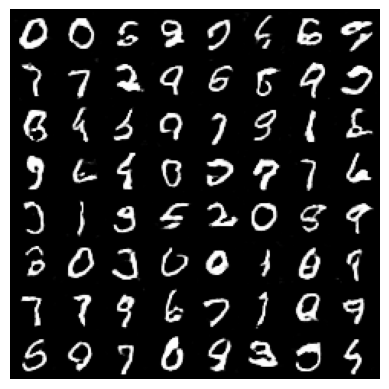

Epoch [10/50], Batch [100/937], D_real: 0.8715, D_fake: 0.1009, Loss_D: 0.3001, Loss_G: 2.7213
Epoch [10/50], Batch [200/937], D_real: 0.8336, D_fake: 0.0578, Loss_D: 0.2718, Loss_G: 3.0386
Epoch [10/50], Batch [300/937], D_real: 0.9583, D_fake: 0.3655, Loss_D: 0.5802, Loss_G: 1.6026
Epoch [10/50], Batch [400/937], D_real: 0.9038, D_fake: 0.1759, Loss_D: 0.3376, Loss_G: 2.6760
Epoch [10/50], Batch [500/937], D_real: 0.9504, D_fake: 0.1951, Loss_D: 0.3292, Loss_G: 1.9690
Epoch [10/50], Batch [600/937], D_real: 0.8351, D_fake: 0.0902, Loss_D: 0.3231, Loss_G: 2.6010
Epoch [10/50], Batch [700/937], D_real: 0.8893, D_fake: 0.0814, Loss_D: 0.2264, Loss_G: 2.7726
Epoch [10/50], Batch [800/937], D_real: 0.8789, D_fake: 0.1881, Loss_D: 0.4012, Loss_G: 2.8429
Epoch [10/50], Batch [900/937], D_real: 0.6170, D_fake: 0.1737, Loss_D: 0.8561, Loss_G: 1.3855


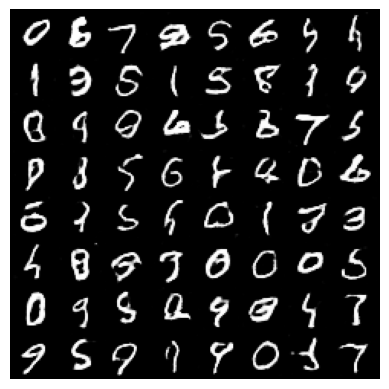

Epoch [11/50], Batch [100/937], D_real: 0.8852, D_fake: 0.1158, Loss_D: 0.2746, Loss_G: 3.0728
Epoch [11/50], Batch [200/937], D_real: 0.8701, D_fake: 0.2436, Loss_D: 0.4816, Loss_G: 2.5495
Epoch [11/50], Batch [300/937], D_real: 0.9037, D_fake: 0.0660, Loss_D: 0.1958, Loss_G: 3.4168
Epoch [11/50], Batch [400/937], D_real: 0.7554, D_fake: 0.1051, Loss_D: 0.4921, Loss_G: 2.2898
Epoch [11/50], Batch [500/937], D_real: 0.9585, D_fake: 0.1761, Loss_D: 0.2632, Loss_G: 3.3179
Epoch [11/50], Batch [600/937], D_real: 0.7132, D_fake: 0.0744, Loss_D: 0.5208, Loss_G: 2.6943
Epoch [11/50], Batch [700/937], D_real: 0.9062, D_fake: 0.2043, Loss_D: 0.3924, Loss_G: 1.8822
Epoch [11/50], Batch [800/937], D_real: 0.4985, D_fake: 0.0280, Loss_D: 1.0289, Loss_G: 4.5483
Epoch [11/50], Batch [900/937], D_real: 0.9143, D_fake: 0.0353, Loss_D: 0.1354, Loss_G: 4.2405


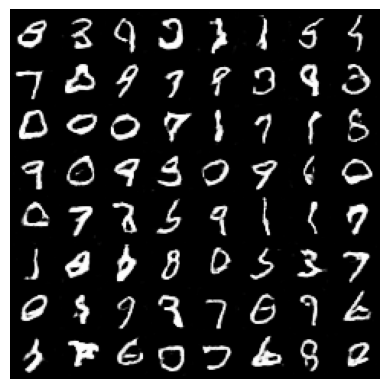

Epoch [12/50], Batch [100/937], D_real: 0.6349, D_fake: 0.1223, Loss_D: 0.7435, Loss_G: 2.5055
Epoch [12/50], Batch [200/937], D_real: 0.9674, D_fake: 0.4031, Loss_D: 0.6621, Loss_G: 1.5843
Epoch [12/50], Batch [300/937], D_real: 0.7578, D_fake: 0.0832, Loss_D: 0.4521, Loss_G: 2.6326
Epoch [12/50], Batch [400/937], D_real: 0.6843, D_fake: 0.1297, Loss_D: 0.6377, Loss_G: 2.0869
Epoch [12/50], Batch [500/937], D_real: 0.8462, D_fake: 0.0867, Loss_D: 0.3026, Loss_G: 3.3502
Epoch [12/50], Batch [600/937], D_real: 0.9609, D_fake: 0.1019, Loss_D: 0.1599, Loss_G: 3.2214
Epoch [12/50], Batch [700/937], D_real: 0.9144, D_fake: 0.1526, Loss_D: 0.2868, Loss_G: 2.5625
Epoch [12/50], Batch [800/937], D_real: 0.6160, D_fake: 0.0763, Loss_D: 0.7282, Loss_G: 2.5148
Epoch [12/50], Batch [900/937], D_real: 0.8985, D_fake: 0.1165, Loss_D: 0.2864, Loss_G: 2.7102


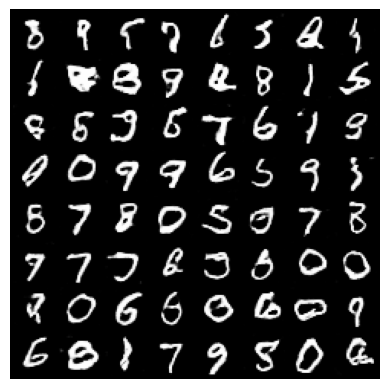

Epoch [13/50], Batch [100/937], D_real: 0.9342, D_fake: 0.0729, Loss_D: 0.1677, Loss_G: 3.6860
Epoch [13/50], Batch [200/937], D_real: 0.9046, D_fake: 0.0582, Loss_D: 0.1779, Loss_G: 2.6862
Epoch [13/50], Batch [300/937], D_real: 0.8882, D_fake: 0.1223, Loss_D: 0.2747, Loss_G: 3.4049
Epoch [13/50], Batch [400/937], D_real: 0.9491, D_fake: 0.2032, Loss_D: 0.3102, Loss_G: 2.2146
Epoch [13/50], Batch [500/937], D_real: 0.9439, D_fake: 0.1995, Loss_D: 0.3382, Loss_G: 2.3765
Epoch [13/50], Batch [600/937], D_real: 0.9734, D_fake: 0.6079, Loss_D: 1.3930, Loss_G: 2.2985
Epoch [13/50], Batch [700/937], D_real: 0.8851, D_fake: 0.0915, Loss_D: 0.2461, Loss_G: 2.4591
Epoch [13/50], Batch [800/937], D_real: 0.9215, D_fake: 0.1420, Loss_D: 0.2820, Loss_G: 3.1091
Epoch [13/50], Batch [900/937], D_real: 0.9137, D_fake: 0.1005, Loss_D: 0.2158, Loss_G: 2.5482


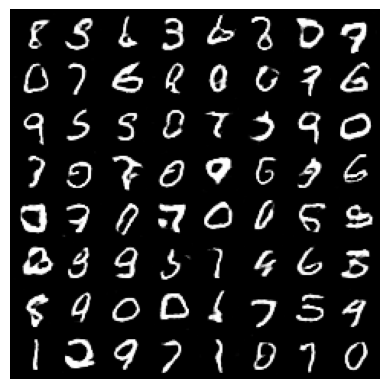

Epoch [14/50], Batch [100/937], D_real: 0.8269, D_fake: 0.0278, Loss_D: 0.2585, Loss_G: 3.6182


KeyboardInterrupt: 

In [239]:
# Training loop
for epoch in range(num_epochs):
    for i, (imgs, _) in enumerate(train_dataloader):
        imgs = imgs.to(device)
        batch_size = imgs.size(0)

        # Train discriminator with real images
        optimizer_d.zero_grad()
        label_real = torch.ones(batch_size, 1).to(device)
        output_real = discriminator(imgs).view(-1, 1)
        loss_real = criterion(output_real, label_real)
        loss_real.backward()

        # Train discriminator with fake images
        noise = torch.randn(batch_size, latent_dim, 1, 1).to(device)
        fake_images = generator(noise)
        label_fake = torch.zeros(batch_size, 1).to(device)
        output_fake = discriminator(fake_images.detach()).view(-1, 1)
        loss_fake = criterion(output_fake, label_fake)
        loss_fake.backward()
        optimizer_d.step()

        # Train generator
        optimizer_g.zero_grad()
        output = discriminator(fake_images).view(-1, 1)
        loss_g = criterion(output, label_real)
        loss_g.backward()
        optimizer_g.step()

        if (i + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{i+1}/{len(train_dataloader)}], '
                  f'D_real: {output_real.mean():.4f}, D_fake: {output_fake.mean():.4f}, '
                  f'Loss_D: {loss_real.item() + loss_fake.item():.4f}, Loss_G: {loss_g.item():.4f}')
            # Generate and save sample images at the end of each epoch
    with torch.no_grad():
        fake_samples = generator(torch.randn(64, latent_dim, 1, 1).to(device))
        fake_samples = fake_samples.cpu()
        fake_grid = vutils.make_grid(fake_samples, padding=2, normalize=True)
        plt.imshow(np.transpose(fake_grid, (1, 2, 0)))
        plt.axis('off')
        plt.show()

Seems like the GAN model is working good as the images from first epoch to 13th epoch has improved so much.
I didn't trained it for 50 epochs because it was taking to much time on my personal computer.

Saving the model for the later use.

In [241]:
from pathlib import Path

model_path = Path('models')
torch.save(generator, model_path/"mnist"/"generator-mnist.pth")
torch.save(discriminator, model_path/"mnist"/"discriminator-mnist.pth")